In [1]:
# mount google drive on your runtime using and authorization code.
# more details here: https://colab.research.google.com/notebooks/io.ipynb
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing libraries and setting random set so we all get same results

In [2]:
# import libraries
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
import pickle
import cv2
from google.colab.patches import cv2_imshow
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# check GPU is available
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

# set random seed to be used all over
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
#os.environ['TF_DETERMINISTIC_OPS'] = '1' #deterministic behavior in TensorFlow operations.
tf.keras.utils.set_random_seed(SEED)
tf.compat.v1.set_random_seed(SEED)
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,log_device_placement =True)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = config)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0



#Getting the dataset

In [3]:
# Path to the directory containing the your project info (Change to your location)
PROJECT_ROOT_DIR = '/content/drive/MyDrive/Datasets/CS5331_Fall24/img/'

# Path to the directory containing the dataset
# DOWNLOAD BUSI dataset here: https://scholar.cu.edu.eg/?q=afahmy/pages/dataset
DATA_DIR = 'Dataset_BUSI_with_GT/'

In [4]:
# Funciton for loading the dataset
# reference: https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/

def load_image():
  # initialize the data and labels for each class
  data = []
  labels = []

  data_aside = []
  labels_aside = []

  benign_data = []
  benign_labels = []

  malignant_data = []
  malignant_labels = []

  normal_data = []
  normal_labels = []

  # load benign image
  for i in range(1,438):
    image = cv2.imread(PROJECT_ROOT_DIR + DATA_DIR + 'benign/' + 'benign (' + str(i) + ').png')
    # resize image to 224 * 224 * 3
    image = cv2.resize(image, (224, 224))
    benign_data.append(image)
    # extract the class label from the image folder
    benign_labels.append('benign')

  for i in range(0,437):
      data.append(benign_data[i])
      labels.append(benign_labels[i])

  # load malignant image
  for i in range(1,211):
    image = cv2.imread(PROJECT_ROOT_DIR + DATA_DIR + 'malignant/' + 'malignant (' + str(i) + ').png')
    # resize image to 224 * 224 * 3
    image = cv2.resize(image, (224, 224))
    malignant_data.append(image)
    # extract the class label from the image folder
    malignant_labels.append('malignant')

  for i in range(0,210):
      data.append(malignant_data[i])
      labels.append(malignant_labels[i])

  # load normal image
  for i in range(1,134):
    image = cv2.imread(PROJECT_ROOT_DIR + DATA_DIR + 'normal/' + 'normal (' + str(i) + ').png')
    # resize image to 224 * 224 * 3
    image = cv2.resize(image, (224, 224))
    normal_data.append(image)
    # extract the class label from the image folder
    normal_labels.append('normal')

  for i in range(0,133):
      data.append(normal_data[i])
      labels.append(normal_labels[i])

  return data, labels
# Function for image preprocessing
def preprocess(data,labels):
  # Save training and test image to numpy, Scale image features to be in [0, 1]
  data = np.array(data, dtype = np.float32) / 255.0
  # Save labels to numpy encode label to integer catergory 0 = 'benign', 1 = 'malignant', 2 = 'normal'
  labels = np.array(labels)
  new_label_encoder = preprocessing.LabelEncoder()
  new_label_encoder.fit(labels)
  targets = new_label_encoder.transform(labels)

  return data, targets

In [5]:
# Load the BUSI images and labels
# This will take time (my time was around 12 min)
data, labels = load_image()
data, labels = preprocess(data,labels)

# split data into 80% train and 20% test, shuffle the data with
(imgs_train, imgs_test, labels_train, labels_test) = train_test_split(data, labels, test_size = 0.2, random_state=SEED, shuffle = True)
# split data into 60% train data and 20% validation data
(imgs_train, imgs_val, labels_train, labels_val) = train_test_split(imgs_train, labels_train, test_size = 0.2, random_state=SEED, shuffle = True)

In [6]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(imgs_train.shape, labels_train.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(imgs_val.shape, labels_val.shape))
print('Images test shape: {} - Labels test shape: {}'.format(imgs_test.shape, labels_test.shape))


Images train shape: (499, 224, 224, 3) - Labels train shape: (499,)
Images validation shape: (125, 224, 224, 3) - Labels validation shape: (125,)
Images test shape: (156, 224, 224, 3) - Labels test shape: (156,)


# Set constants

In [7]:
NUM_LABELS = 3                             # Number of labels
BATCH_SIZE = 16                             # Size of batch
HEIGHT = 224                                 # Height of input image
WIDTH = 224                                  # Width of input image
N_CHANNEL = 3                               # Number of channels
OUTPUT_DIM = 3                             # Number of output dimension

# Set training hyperparameters
NUM_EPOCH = 100                             # Number of epoch to train
LR = 0.0001                                 # Learning rate

INPUT_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)  # Input shape of model
IMG_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)

# Converting the labels

In [8]:
from tensorflow import keras
labels_train = keras.utils.to_categorical(labels_train, NUM_LABELS)
labels_test = keras.utils.to_categorical(labels_test, NUM_LABELS)
labels_val = keras.utils.to_categorical(labels_val, NUM_LABELS)

# Task1: Simple CNN

In [9]:
# For your first task, you will train a Convolutional Natural Network (CCN) model with the parameters in Table 1 and provide us with the results.
# You can use already developed models for Kears, TensorFlow, and PyTorch. You don’t need to implement the models’ layers yourself.
# For this task, you don’t need to do hyper-parameter tuning, apply data augmentation, or fine-tune the layers of the models unless you wish to.

# Here few steps that you could follow


# Import what ever libraries you need
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import cv2

In [10]:
# Build your network
def build_cnn(input_shape, num_labels):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_labels, activation='softmax'))  # For classification into 3 categories
    return model


# Create and compile the pretrained model
cnn_model = build_cnn(INPUT_SHAPE, NUM_LABELS)
cnn_model.compile(optimizer=Adam(learning_rate=LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,779 (91.20 MB)

 Trainable params: 23,907,779 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train/Fit the model
history = cnn_model.fit(imgs_train, labels_train,
                        validation_data=(imgs_val, labels_val),
                        epochs=NUM_EPOCH,
                        batch_size=BATCH_SIZE)

# evaluate Your model
test_loss, test_acc = cnn_model.evaluate(imgs_test, labels_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.5076 - loss: 1.0141 - val_accuracy: 0.5840 - val_loss: 1.0246
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5552 - loss: 0.9876 - val_accuracy: 0.6320 - val_loss: 0.8378
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6077 - loss: 0.8072 - val_accuracy: 0.6240 - val_loss: 0.8687
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6606 - loss: 0.7222 - val_accuracy: 0.6240 - val_loss: 0.8992
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7075 - loss: 0.6286 - val_accuracy: 0.6320 - val_loss: 0.8613
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7853 - loss: 0.5053 - val_accuracy: 0.6640 - val_loss: 0.8053
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8518 - loss: 0.3939 - val_accuracy: 0.6960 - val_loss: 0.7124
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8815 - loss: 0.3164 - val_accuracy: 0.6640 

In [12]:
train_accuracy = history.history['accuracy'][-1]
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

val_accuracy = history.history['val_accuracy'][-1]
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

Training Accuracy: 100.00%
Validation Accuracy: 69.60%


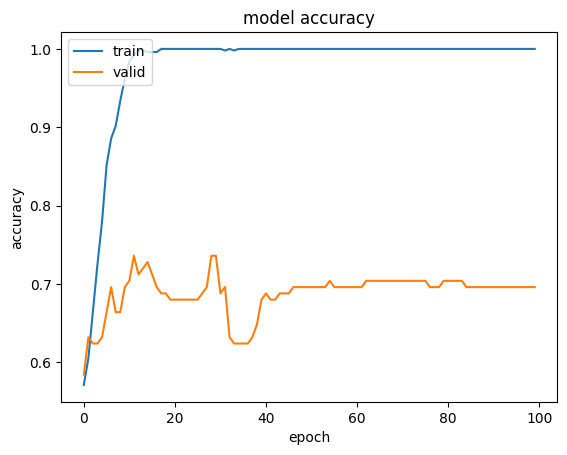

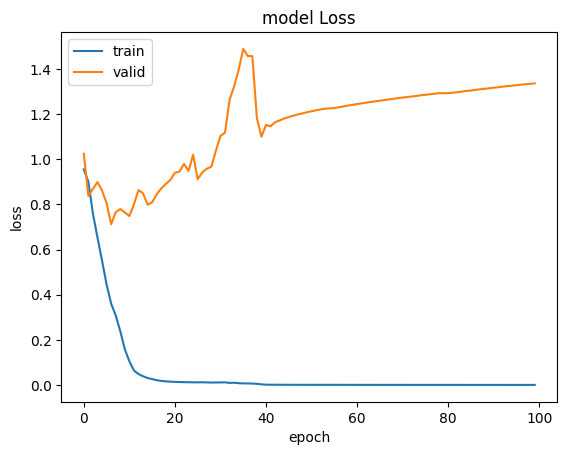

In [13]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# save model
cnn_model.save('/content/drive/MyDrive/2Layer_CNN_Model.h5')

# Task 2: Enhance the performance


In [14]:
# CS5331/CS4331 You should Impliment this part
# Task 2 Impliment an enhanced DL performance
# You must train a DL model to achieve 85% or above testing accuracy.
# You are restricted to using the parameters provided in Table 3.
# You should start with pre-trained weights (e.g., on ImageNet, which is already available on Keras). It should result in a better performance.
# Any other hyper-parameter tuning, DL model use, data augmentation, or fine-tuning of the layers of the models is fine as long as you reach the desired accuracy.
# You will need to try at least a couple of parameters to reach the desired accuracy.

# Here few steps that you could follow

# Import what ever libraries you need
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [24]:
IMG_SIZE = (224, 224)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data with augmentation
train_data = train_datagen.flow_from_directory(
    PROJECT_ROOT_DIR + DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation data without augmentation
val_data = val_datagen.flow_from_directory(
    PROJECT_ROOT_DIR + DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 1263 images belonging to 3 classes.
Found 315 images belonging to 3 classes.


In [18]:
# Load some pretrained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_LABELS, activation='softmax')(x)

In [19]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,688,963 (98.00 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
# # Train/Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# # Train the model
# history = model.fit(
#     train_data,
#     validation_data=val_data,
#     epochs=NUM_EPOCH,
#     batch_size=BATCH_SIZE,
#     callbacks=[early_stopping, reduce_lr]
# )

In [26]:
# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers of base model
    layer.trainable = True

# Compile the model again with a lower learning rate
model.compile(optimizer=Adam(learning_rate=LR/10),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=NUM_EPOCH,
    batch_size=BATCH_SIZE,
    callbacks=[reduce_lr]
)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 370ms/step - accuracy: 0.8367 - loss: 0.3899 - val_accuracy: 0.7302 - val_loss: 0.9035 - learning_rate: 1.0000e-05
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 263ms/step - accuracy: 0.8345 - loss: 0.3842 - val_accuracy: 0.7587 - val_loss: 0.6645 - learning_rate: 1.0000e-05
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 260ms/step - accuracy: 0.8259 - loss: 0.3894 - val_accuracy: 0.7714 - val_loss: 0.6000 - learning_rate: 1.0000e-05
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 260ms/step - accuracy: 0.8491 - loss: 0.3505 - val_accuracy: 0.7683 - val_loss: 0.5809 - learning_rate: 1.0000e-05
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 261ms/step - accuracy: 0.8534 - loss: 0.3680 - val_accuracy: 0.7556 - val_loss: 0.6526 - learning_rate: 1.0000e-05
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 261ms/step - accuracy: 0.8827 - loss: 0.3135 - val_accuracy: 0.7587 - val_loss: 0.6487 - learning_rate: 1.0000e-05
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 260ms/ste

In [27]:
# Load test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    PROJECT_ROOT_DIR + DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Found 1578 images belonging to 3 classes.
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.9241 - loss: 0.2138
Test Accuracy: 92.40%


In [28]:
train_accuracy = fine_tune_history.history['accuracy'][-1]
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

val_accuracy = fine_tune_history.history['val_accuracy'][-1]
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

Training Accuracy: 93.03%
Validation Accuracy: 79.05%


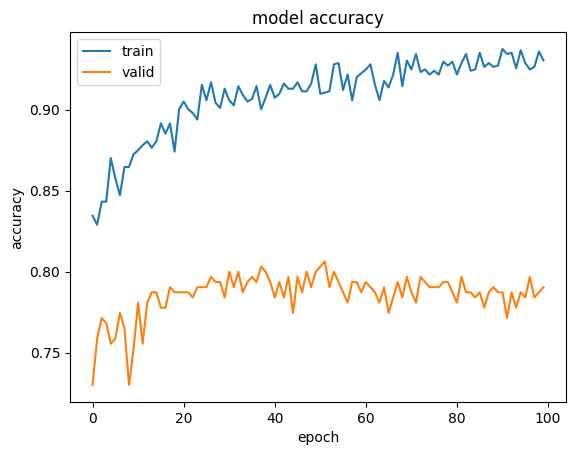

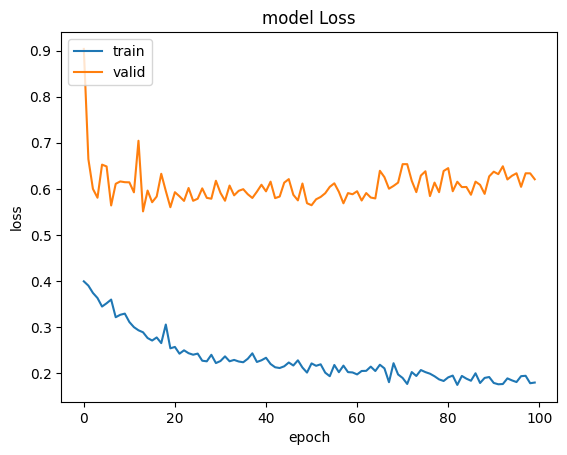

In [29]:
# Plot accuracy
plt.plot(fine_tune_history.history['accuracy'], label='train')
plt.plot(fine_tune_history.history['val_accuracy'], label='valid')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(fine_tune_history.history['loss'], label='train')
plt.plot(fine_tune_history.history['val_loss'], label='valid')
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# save model
model.save('Enhanced_CNN_model.h5')

# Taks 3: Avoiding Overfitting



In [30]:
# CS5331/CS4331 You should Impliment this part

# Now, let’s fix the problem with the previous model. Most models in the last task were overfitting (training accuracy got to 100% so quickly, and validation accuracy started to decrease).
# Fix that problem without changing the batch size, number of iterations, or learning rate.
# Any avoiding overfitting can be used. Just keep the parameters in Table 3 the same.

# Here few steps that you could follow


# Import what ever libraries you need
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [31]:
# Load some pretrained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to avoid training them
base_model.trainable = False

# Add custom layers for classification
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
# Data augmentation to prevent overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load training and validation data
train_data = train_datagen.flow_from_directory(
    PROJECT_ROOT_DIR + DATA_DIR,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    PROJECT_ROOT_DIR + DATA_DIR,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 1263 images belonging to 3 classes.
Found 315 images belonging to 3 classes.


In [33]:
# Train/Fit the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=NUM_EPOCH,
    batch_size=BATCH_SIZE
)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 403ms/step - accuracy: 0.4802 - loss: 2.3093 - val_accuracy: 0.5651 - val_loss: 1.7709
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 297ms/step - accuracy: 0.5639 - loss: 1.7606 - val_accuracy: 0.6381 - val_loss: 1.4332
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 297ms/step - accuracy: 0.5528 - loss: 1.4754 - val_accuracy: 0.6127 - val_loss: 1.2353
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 296ms/step - accuracy: 0.6052 - loss: 1.2219 - val_accuracy: 0.6254 - val_loss: 1.1249
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 296ms/step - accuracy: 0.6272 - loss: 1.1170 - val_accuracy: 0.6349 - val_loss: 1.0235
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 294ms/step - accuracy: 0.6119 - loss: 1.0360 - val_accuracy: 0.6286 - val_loss: 0.9854
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 297ms/step - accuracy: 0.6332 - loss: 0.9944 - val_accuracy: 0.6508 - val_loss: 0.9433
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 296ms/step - accuracy: 0.6521 - loss: 0.9676 - 

In [34]:
# Load test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    PROJECT_ROOT_DIR + DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Found 1578 images belonging to 3 classes.
 1/99 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.6875 - loss: 0.7617

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.7659 - loss: 0.6157
Test Accuracy: 75.35%


In [35]:
train_accuracy = history.history['accuracy'][-1]
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

val_accuracy = history.history['val_accuracy'][-1]
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

Training Accuracy: 74.90%
Validation Accuracy: 70.16%


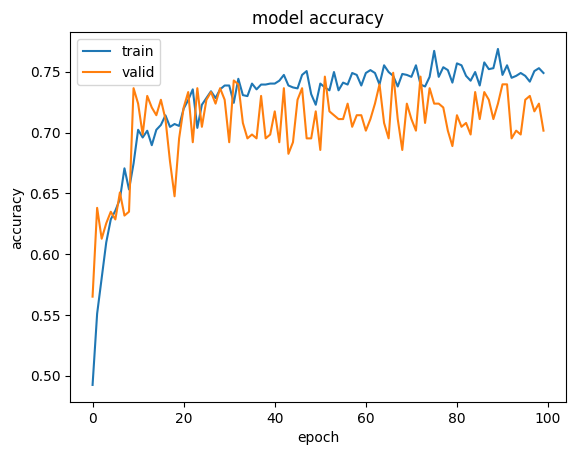

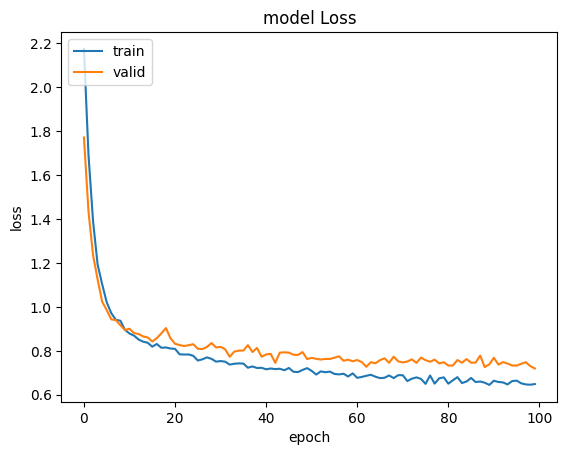

In [36]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# save model
model.save('Task3_CNN_model.h5')